# Combined  Model (XGBoost Undersampling + XGBoost Regression)


In [1]:
%load_ext jupyter_black

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import shap
import imblearn
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBClassifier
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from matplotlib import cm
from mlxtend.plotting import plot_confusion_matrix
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

from utils import get_training_dataset

In [3]:
# Read csv file and import to df
df = get_training_dataset()
df.head()

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,...,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged,percent_houses_damaged_5years
0,DURIAN,2006,101,0.0,303.180555,0.122917,0.085417,31.000000,NaN,1.018526,...,2.699781,5.762712,3445.709753,1,0.0,0.00,1.00,0.000000,0.0,0.0
1,DURIAN,2006,4475,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,1.579400,...,4.585088,12.799127,8602.645832,1,0.0,0.00,1.00,0.000000,0.0,0.0
2,DURIAN,2006,4639,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,0.551764,...,1.527495,8.833333,5084.012925,1,0.0,0.01,0.99,197.339034,0.0,0.0
3,DURIAN,2006,4640,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,2.107949,...,11.677657,17.530431,55607.865950,1,0.0,0.31,0.69,4970.477311,0.0,0.0
4,DURIAN,2006,4641,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,3.538881,...,17.074011,31.931338,35529.342507,1,0.0,0.77,0.23,12408.594656,0.0,0.0


In [4]:
# Fill NaNs with average estimated value of 'rwi'
df["rwi"].fillna(df["rwi"].mean(), inplace=True)

# Set any values >100% to 100%,
for i in range(len(df)):
    if df.loc[i, "percent_houses_damaged"] > 100:
        df.at[i, "percent_houses_damaged"] = float(100)

In [5]:
# Define a threshold to separate target into damaged and not_damaged
thres = 10.0

for i in range(len(df)):
    if df.loc[i, "percent_houses_damaged"] >= thres:
        df.at[i, "binary_damage"] = 1
    else:
        df.at[i, "binary_damage"] = 0

df["binary_damage"] = df["binary_damage"].astype("int")
df

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,...,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged,percent_houses_damaged_5years,binary_damage
0,DURIAN,2006,101,0.0,303.180555,0.122917,0.085417,31.000000,-0.213039,1.018526,...,5.762712,3445.709753,1,0.00,0.000000,1.000000,0.000000,0.0,0.000000,0
1,DURIAN,2006,4475,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,1.579400,...,12.799127,8602.645832,1,0.00,0.000000,1.000000,0.000000,0.0,0.000000,0
2,DURIAN,2006,4639,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,0.551764,...,8.833333,5084.012925,1,0.00,0.010000,0.990000,197.339034,0.0,0.000000,0
3,DURIAN,2006,4640,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,2.107949,...,17.530431,55607.865950,1,0.00,0.310000,0.690000,4970.477311,0.0,0.000000,0
4,DURIAN,2006,4641,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,3.538881,...,31.931338,35529.342507,1,0.00,0.770000,0.230000,12408.594656,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141253,MOLAVE,2020,20677,0.0,644.575831,2.543750,0.778646,4449.357133,0.508167,3.790141,...,36.304688,21559.003490,1,0.08,0.080000,0.840000,17619.701390,0.0,0.000000,0
141254,MOLAVE,2020,20678,0.0,655.685233,2.558333,0.861458,1521.435795,-0.174100,3.532580,...,65.687266,12591.742022,1,0.00,0.420000,0.580000,5623.069564,0.0,0.000000,0
141255,MOLAVE,2020,20679,0.0,666.794635,2.975000,0.949479,930.647069,-0.244286,4.444498,...,37.414996,19740.596834,1,0.00,0.109091,0.890909,5912.671746,0.0,0.015207,0
141256,MOLAVE,2020,20680,0.0,677.904037,2.889583,1.083333,1800.666044,0.038000,5.816195,...,105.812452,26363.303778,1,0.03,0.250000,0.720000,11254.164413,0.0,0.020806,0


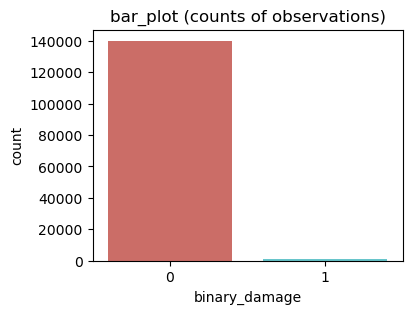

In [6]:
# Show bar plot
plt.figure(figsize=(4, 3))
sns.countplot(x="binary_damage", data=df, palette="hls")
plt.title("bar_plot (counts of observations)")
plt.show()

In [7]:
# Remove zeros from wind_speed
df = (df[(df[["wind_speed"]] != 0).any(axis=1)]).reset_index(drop=True)
df = df.drop(columns=["grid_point_id", "typhoon_year"])
df.head()

,typhoon_name,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,std_slope,mean_tri,...,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged,percent_houses_damaged_5years,binary_damage
0,DURIAN,12.460039,275.018491,0.670833,0.313021,0.479848,-0.213039,12.896581,7.450346,74.625539,...,42.218750,5303.659490,1,0.00,0.00,1.00,0.000000,0.0,0.0,0
1,DURIAN,11.428974,297.027578,0.929167,0.343229,55.649739,0.206000,14.070741,6.514647,68.681417,...,72.283154,61015.543599,1,0.00,0.14,0.86,276.871504,0.0,0.0,0
2,DURIAN,13.077471,262.598363,0.716667,0.424479,8.157414,-0.636000,19.758682,10.940700,104.453163,...,102.215198,66707.438070,1,0.00,0.11,0.89,448.539453,0.0,0.0,0
3,DURIAN,12.511864,273.639330,0.568750,0.336979,88.292015,-0.227500,11.499097,6.901584,59.798108,...,58.988877,53841.050168,1,0.00,0.12,0.88,2101.708435,0.0,0.0,0
4,DURIAN,11.977511,284.680297,0.589583,0.290625,962.766739,-0.299667,13.866633,6.528689,65.655280,...,111.386527,87378.257957,1,0.07,0.46,0.47,11632.726327,0.0,0.0,0


array([[<AxesSubplot:title={'center':'binary_damage'}>]], dtype=object)

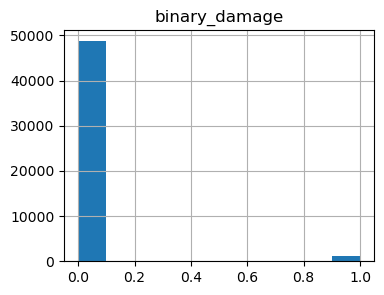

In [8]:
# Show histogram of damage
bins2 = [0, 0.1, 1]
df.hist(column="binary_damage", figsize=(4, 3))

In [9]:
# Define bins for data stratification
bins2 = [0, 0.1, 1]
samples_per_bin2, binsP2 = np.histogram(df["binary_damage"], bins=bins2)

In [10]:
# Check the bins' intervalls (first bin means all zeros, second bin means 0 < values <= 1)
df["binary_damage"].value_counts(bins=binsP2)

(-0.001, 0.1]    48685
(0.1, 1.0]        1069
Name: binary_damage, dtype: int64

In [11]:
print(samples_per_bin2)
print(binsP2)

[48685  1069]
[0.  0.1 1. ]


In [12]:
bin_index2 = np.digitize(df["binary_damage"], bins=binsP2)

In [13]:
y_input_strat = bin_index2

In [14]:
features = [
    "wind_speed",
    "track_distance",
    "total_houses",
    "rainfall_max_6h",
    "rainfall_max_24h",
    "rwi",
    "mean_slope",
    "std_slope",
    "mean_tri",
    "std_tri",
    "mean_elev",
    "coast_length",
    "with_coast",
    "urban",
    "rural",
    "water",
    "total_pop",
    "percent_houses_damaged_5years",
]

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["binary_damage"]

Index(['wind_speed', 'track_distance', 'total_houses', 'rainfall_max_6h',
       'rainfall_max_24h', 'rwi', 'mean_slope', 'std_slope', 'mean_tri',
       'std_tri', 'mean_elev', 'coast_length', 'with_coast', 'urban', 'rural',
       'water', 'total_pop', 'percent_houses_damaged_5years'],
      dtype='object')

In [15]:
# Define train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    df["binary_damage"],
    test_size=0.2,
    stratify=y_input_strat,
)

In [16]:
print(Counter(y_train))

Counter({0: 38948, 1: 855})


In [17]:
# Undersampling

# Define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.7)
# Fit and apply the transform
X_train, y_train = under.fit_resample(X_train, y_train)

print(Counter(y_train))

Counter({0: 1221, 1: 855})


In [18]:
# Use XGBClassifier as a Machine Learning model to fit the data
xgb_model = XGBClassifier()

eval_set = [(X_train, y_train), (X_test, y_test)]
# eval_set = [(X_test, y_test)]
xgb_model.fit(
    X_train,
    y_train,
    eval_metric=["error", "logloss"],
    eval_set=eval_set,
    verbose=False,
)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [19]:
# Make prediction for all the X data
y_pred_all = xgb_model.predict(X)

In [20]:
# y_pred = xgb_model.predict(X_test)
cm = confusion_matrix(y, y_pred_all)
cm

array([[45763,  2922],
       [   12,  1057]])

In [21]:
# Print Confusion Matrix
print(metrics.confusion_matrix(y, y_pred_all))

[[45763  2922]
 [   12  1057]]


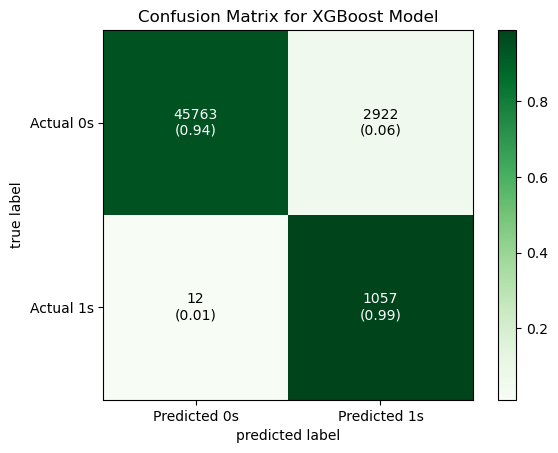

In [22]:
# Plot Confusion Matrix
fig, ax = plot_confusion_matrix(
    conf_mat=cm,
    show_absolute=True,
    show_normed=True,
    colorbar=True,
    cmap=plt.cm.Greens,
)

ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=("Predicted 0s", "Predicted 1s"))
ax.yaxis.set(ticks=(0, 1), ticklabels=("Actual 0s", "Actual 1s"))
plt.title("Confusion Matrix for XGBoost Model")
plt.show()

In [23]:
# Print Classification Report
print(metrics.classification_report(y, y_pred_all))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     48685
           1       0.27      0.99      0.42      1069

    accuracy                           0.94     49754
   macro avg       0.63      0.96      0.69     49754
weighted avg       0.98      0.94      0.96     49754



In [24]:
# Add real and predicted values to df
for i in range(len(X)):
    df.at[i, "binary_damage"] = y.tolist()[i]
    df.at[i, "predicted_value"] = y_pred_all[i]

df["binary_damage"] = df["binary_damage"].astype("int")
df["predicted_value"] = df["predicted_value"].astype("int")

df

,typhoon_name,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,std_slope,mean_tri,...,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged,percent_houses_damaged_5years,binary_damage,predicted_value
0,DURIAN,12.460039,275.018491,0.670833,0.313021,0.479848,-0.213039,12.896581,7.450346,74.625539,...,5303.659490,1,0.00,0.000000,1.000000,0.000000,0.0,0.000000,0,0
1,DURIAN,11.428974,297.027578,0.929167,0.343229,55.649739,0.206000,14.070741,6.514647,68.681417,...,61015.543599,1,0.00,0.140000,0.860000,276.871504,0.0,0.000000,0,0
2,DURIAN,13.077471,262.598363,0.716667,0.424479,8.157414,-0.636000,19.758682,10.940700,104.453163,...,66707.438070,1,0.00,0.110000,0.890000,448.539453,0.0,0.000000,0,0
3,DURIAN,12.511864,273.639330,0.568750,0.336979,88.292015,-0.227500,11.499097,6.901584,59.798108,...,53841.050168,1,0.00,0.120000,0.880000,2101.708435,0.0,0.000000,0,0
4,DURIAN,11.977511,284.680297,0.589583,0.290625,962.766739,-0.299667,13.866633,6.528689,65.655280,...,87378.257957,1,0.07,0.460000,0.470000,11632.726327,0.0,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49749,MOLAVE,8.011792,255.535258,2.256250,1.056771,41.979062,-0.742000,10.019319,7.973423,51.666178,...,1929.419748,1,0.01,0.000000,0.990000,330.215768,0.0,1.143833,0,0
49750,MOLAVE,7.617460,266.645258,2.170833,0.933854,1625.734579,-0.096571,3.962696,3.907937,20.118420,...,45965.284119,1,0.05,0.190000,0.760000,5409.607943,0.0,1.143833,0,0
49751,MOLAVE,7.170117,277.755258,1.918750,0.833333,624.597557,0.190000,3.952812,3.697735,21.629590,...,14744.712453,1,0.01,0.020000,0.970000,5378.401365,0.0,1.143833,0,0
49752,MOLAVE,6.834925,288.864374,3.747917,1.161310,18.445345,-0.320000,4.054233,2.507445,24.421430,...,5376.583753,1,0.00,0.027273,0.972727,914.677196,0.0,1.143833,0,0


In [25]:
# Remove rows where predicted_value == 0
df = df.drop(df.loc[df["predicted_value"] == 0].index)
df

,typhoon_name,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,std_slope,mean_tri,...,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged,percent_houses_damaged_5years,binary_damage,predicted_value
76,DURIAN,45.534678,44.163867,6.702083,3.014062,484.095129,-0.248000,2.175724,1.723689,10.620567,...,13003.187302,1,0.00,0.09,0.91,978.781677,0.150797,0.000000,0,1
97,DURIAN,20.365690,166.781031,1.502083,0.829167,12786.598717,0.210368,1.082532,2.294620,6.665070,...,11698.289692,1,0.44,0.45,0.11,72836.147524,17.919364,0.000000,1,1
100,DURIAN,45.714626,44.581480,6.868750,2.890104,1415.092713,-0.594000,1.166636,1.205199,6.404116,...,13331.274042,1,0.00,0.15,0.85,1574.509612,0.150797,0.000000,0,1
101,DURIAN,49.530253,33.472430,8.512500,3.417708,1605.188605,-0.059375,3.339437,4.369079,16.603556,...,21900.263448,1,0.00,0.48,0.52,3235.643653,0.150797,0.000000,0,1
123,DURIAN,49.748480,33.617709,8.058333,3.277083,1492.732249,0.080500,10.032675,7.068233,48.126512,...,22169.770782,1,0.00,0.75,0.25,3044.510684,0.114924,0.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48904,MOLAVE,31.300579,20.804833,15.879167,7.907292,1047.000000,-0.245167,14.017883,5.530483,65.913059,...,35206.558106,1,0.00,0.22,0.78,6025.761218,0.000000,2.112157,0,1
48915,MOLAVE,33.168463,11.775123,11.139583,7.338542,6.359082,-0.291000,7.761711,4.006668,39.335665,...,7614.883914,1,0.00,0.01,0.99,26.183816,1.300488,0.553219,0,1
48994,MOLAVE,30.697148,16.208895,22.758333,9.404167,236.500000,-0.243000,17.671648,8.629585,83.764164,...,7891.860780,1,0.00,0.03,0.97,556.980911,0.845666,1.227222,0,1
49078,MOLAVE,31.569982,18.725560,22.916667,9.758333,2.469247,-0.744000,9.873071,2.888569,51.190970,...,1077.247765,1,0.00,0.00,1.00,26.419608,0.440072,0.489775,0,1


In [ ]:
# Save df to train this new df with regression model
# df.to_csv("data/%damg>10.csv", index=False)

In [27]:
# Define bins for data stratification in regression model
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_houses_damaged"], bins=bins2)

print(samples_per_bin2)
print(binsP2)

[ 786  829 1307  914  143]
[0.00e+00 9.00e-05 1.00e+00 1.00e+01 5.00e+01 1.01e+02]


In [28]:
bin_index2 = np.digitize(df["percent_houses_damaged"], bins=binsP2)

In [29]:
y_input_strat = bin_index2

In [30]:
features = [
    "wind_speed",
    "track_distance",
    "total_houses",
    "rainfall_max_6h",
    "rainfall_max_24h",
    "rwi",
    "mean_slope",
    "std_slope",
    "mean_tri",
    "std_tri",
    "mean_elev",
    "coast_length",
    "with_coast",
    "urban",
    "rural",
    "water",
    "total_pop",
    "percent_houses_damaged_5years",
]

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["percent_houses_damaged"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Index(['wind_speed', 'track_distance', 'total_houses', 'rainfall_max_6h',
       'rainfall_max_24h', 'rwi', 'mean_slope', 'std_slope', 'mean_tri',
       'std_tri', 'mean_elev', 'coast_length', 'with_coast', 'urban', 'rural',
       'water', 'total_pop', 'percent_houses_damaged_5years'],
      dtype='object')

In [31]:
# Define train_test_split function
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df["percent_houses_damaged"], stratify=y_input_strat, test_size=0.2
)

In [32]:
X_train = X_scaled
y_train = df["percent_houses_damaged"]
X_test = X_test
y_test = y_test

In [35]:
# XGBoost Reduced Overfitting
xgb = XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    colsample_bylevel=0.8,
    colsample_bynode=0.8,
    colsample_bytree=0.8,
    gamma=3,
    eta=0.01,
    importance_type="gain",
    learning_rate=0.1,
    max_delta_step=0,
    max_depth=4,
    min_child_weight=1,
    missing=1,
    n_estimators=100,
    early_stopping_rounds=10,
    n_jobs=1,
    nthread=None,
    objective="reg:squarederror",
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    seed=None,
    silent=None,
    subsample=0.8,
    verbosity=1,
    eval_metric=["rmse", "logloss"],
    random_state=0,
)

eval_set = [(X_test, y_test)]
xgb_model = xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

[12:16:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


                              OLS Regression Results                              
Dep. Variable:     percent_houses_damaged   R-squared:                       0.259
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     81.57
Date:                    Fri, 24 Mar 2023   Prob (F-statistic):          1.04e-242
Time:                            12:16:43   Log-Likelihood:                -15938.
No. Observations:                    3979   AIC:                 

In [36]:
y_pred_train = xgb.predict(X_train)
y_pred = xgb.predict(X_test)

In [37]:
# Calculate RMSE in total

mse_train_idx = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train_idx)

mse_idx = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse_idx)

print(f"RMSE_test_in_total: {rmse:.2f}")
print(f"RMSE_train_in_total: {rmse_train:.2f}")

# Calculate RMSE per bins

bin_index_test = np.digitize(y_test, bins=binsP2)
bin_index_train = np.digitize(y_train, bins=binsP2)

RMSE_test_in_total: 9.31
RMSE_train_in_total: 8.56


In [38]:
for bin_num in range(1, 6):

    # Estimation of RMSE for train data
    mse_train_idx = mean_squared_error(
        y_train[bin_index_train == bin_num], y_pred_train[bin_index_train == bin_num]
    )
    rmse_train = np.sqrt(mse_train_idx)

    # Estimation of RMSE for test data
    mse_idx = mean_squared_error(
        y_test[bin_index_test == bin_num], y_pred[bin_index_test == bin_num]
    )
    rmse = np.sqrt(mse_idx)

    print(f"RMSE_test: {rmse:.2f}")
    print(f"RMSE_train: {rmse_train:.2f}")

RMSE_test: 4.96
RMSE_train: 5.34
RMSE_test: 4.14
RMSE_train: 4.59
RMSE_test: 5.01
RMSE_train: 4.84
RMSE_test: 11.71
RMSE_train: 11.46
RMSE_test: 32.51
RMSE_train: 26.60
